In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from analysis_utils import get_df

In [2]:
identifier = '*'
df = get_df(identifier)
print('before filtering, there are a total of', len(df), 'models')

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


before filtering, there are a total of 281 models


In [3]:
df.dtypes

input_size                                              object
output_size                                             object
batch_norm                                              object
use_pooling                                             object
pooling_method                                          object
conv1_kernel_size                                        int64
conv1_num_kernels                                        int64
conv1_stride                                             int64
conv1_dropout                                          float64
pool1_kernel_size                                        int64
pool1_stride                                             int64
conv2_kernel_size                                        int64
conv2_num_kernels                                        int64
conv2_stride                                             int64
conv2_dropout                                          float64
pool2_kernel_size                                      

# Filter by improvement across 3 scan batteries

In [4]:
snr_max_tolerance = 1.0
df_consistent_cnr_snr = df.query('target_anechoic_cyst_5mm_avg_cnr_dnn >= target_anechoic_cyst_5mm_avg_cnr_das & \
               target_phantom_anechoic_cyst_2p5mm_avg_cnr_dnn >= target_phantom_anechoic_cyst_2p5mm_avg_cnr_das & \
               target_in_vivo_avg_cnr_dnn >= target_in_vivo_avg_cnr_das & \
               target_anechoic_cyst_5mm_avg_snr_dnn <= target_anechoic_cyst_5mm_avg_snr_das + ' + str(snr_max_tolerance) + ' & \
               target_phantom_anechoic_cyst_2p5mm_avg_snr_dnn <= target_phantom_anechoic_cyst_2p5mm_avg_snr_das + ' + str(snr_max_tolerance) + ' & \
               target_in_vivo_avg_snr_dnn <= target_in_vivo_avg_snr_das + ' + str(snr_max_tolerance))

In [68]:
len(df_consistent_cnr_snr)

76

# Label rows with consistent or not

In [5]:
df.loc[df.index.isin(df_consistent_cnr_snr.index), 'consistent'] = True
df.loc[~df.index.isin(df_consistent_cnr_snr.index), 'consistent'] = False

In [6]:
# Hyperparameters to look at

hyperparams = [ \
#  'name',
 'batch_norm',
 'use_pooling',
 'conv1_kernel_size',
 'conv1_num_kernels',
 'conv1_stride',
#  'conv1_dropout',
               
 'pool1_kernel_size',
 'pool1_stride',
               
 'conv2_kernel_size',
 'conv2_num_kernels',
 'conv2_stride',
 'conv2_dropout',
               
 'pool2_kernel_size',
 'pool2_stride',
               
 'fcs_hidden_size',
 'fcs_dropout',
 'fcs_num_hidden_layers',
               
               
#  'data_is_target',
 'data_noise_gaussian',
#  'data_train',
#  'data_val',
#  'k',
#  'patience',
#  'save_initial',
#  'weight_decay',
#  'batch_size',
#  'loss_val_k_3',
 'loss_val_k_4',
#  'loss_val_k_5',
          
 'learning_rate',
 'optimizer',
#  'momentum',
]



# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))


# Plotting Helpers

In [32]:
def consistent_vs_inconsistent_histogram(column, **kwargs):
    fig, ax = plt.subplots(1, 1)
    df[df['consistent'] != 1].hist(column, ax=ax, density=True, alpha=0.5, label='Inconsistent', color='red', **kwargs)
    df[df['consistent'] == 1].hist(column, ax=ax, density=True, alpha=0.5, label='Consistent', color='blue', **kwargs)
    ax.legend(loc='upper right')
    plt.show()

# What percentage of consistent models use pooling?

In [8]:
# NOTE: older models may use_pooling hard-coded as 0
# NOTE: There might be older models that don't even have "use_pooling"
print('inconsistent', len(df[~df['consistent'] & df['use_pooling']]) / len(df[~df['consistent']]))
print('consistent', len(df[df['consistent'] & df['use_pooling']]) / len(df[df['consistent']]))

inconsistent 0.25853658536585367
consistent 0.2631578947368421


# What percentage of consistent vs inconsistent models use batch norm?

In [9]:
# NOTE: older models may have batch_norm set to 1
# NOTE: There might be older models that don't even have "batch_norm"
print('inconsistent', len(df[~df['consistent'] & df['batch_norm']]) / len(df[~df['consistent']]))
print('consistent', len(df[df['consistent'] & df['batch_norm']]) / len(df[df['consistent']]))

inconsistent 0.7365853658536585
consistent 0.7368421052631579


# What percentage of consistent vs inconsistent models use gaussian noise?

In [10]:
# NOTE: We've been using gaussian noise since the beginning
print('inconsistent', len(df[~df['consistent'] & df['data_noise_gaussian']]) / len(df[~df['consistent']]))
print('consistent', len(df[df['consistent'] & df['data_noise_gaussian']]) / len(df[df['consistent']]))

inconsistent 0.4926829268292683
consistent 0.6578947368421053


# Distribution of conv1_kernel_size among consistent vs inconsistent models

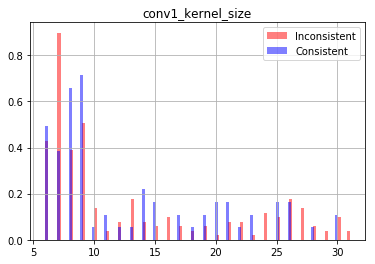

In [62]:
# Note: we didn't allow larger kernel sizes until later
consistent_vs_inconsistent_histogram('conv1_kernel_size', bins=100)

# Distribution of conv1_num_kernels among consistent vs inconsistent models

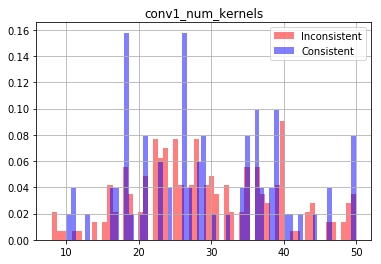

In [64]:
# Note: we didn't allow larger kernel sizes until later
consistent_vs_inconsistent_histogram('conv1_num_kernels', bins=60)

# Distribution of conv1_stride among consistent vs inconsistent models

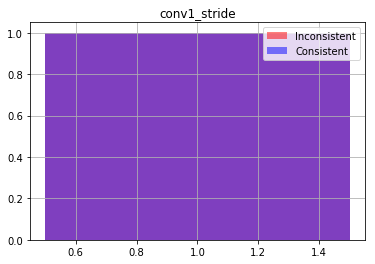

In [39]:
# Note: we didn't allow larger kernel sizes until later
consistent_vs_inconsistent_histogram('conv1_stride', bins=1)

# Distribution of pool1_kernel_size among consistent vs inconsistent models

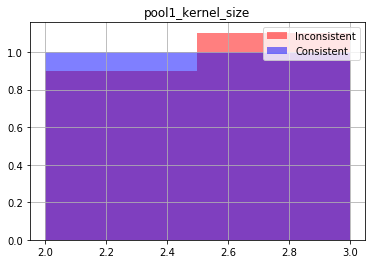

In [45]:
# Note: we didn't allow larger kernel sizes until later
# NOTE: this doesn't consider use_pool == 0
consistent_vs_inconsistent_histogram('pool1_kernel_size', bins=2)

# Distribution of pool1_stride among consistent vs inconsistent models

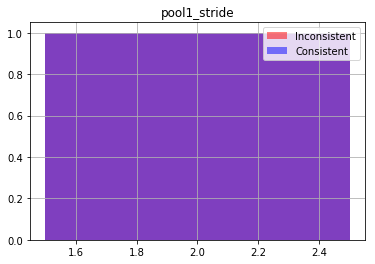

In [46]:
# Note: we didn't allow larger kernel sizes until later
consistent_vs_inconsistent_histogram('pool1_stride', bins=1)

# Distribution of conv2_kernel_size among consistent vs inconsistent models

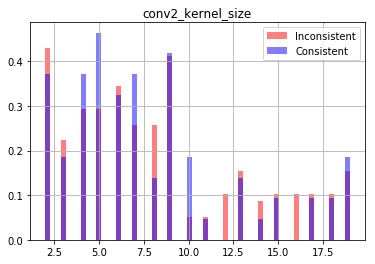

In [63]:
# Note: we didn't allow larger kernel sizes until later
consistent_vs_inconsistent_histogram('conv2_kernel_size', bins=60)

# Distribution of conv2_num_kernels among consistent vs inconsistent models

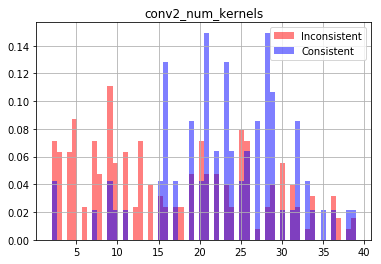

In [66]:
consistent_vs_inconsistent_histogram('conv2_num_kernels', bins=60)

# Distribution of conv2_stride among consistent vs inconsistent models

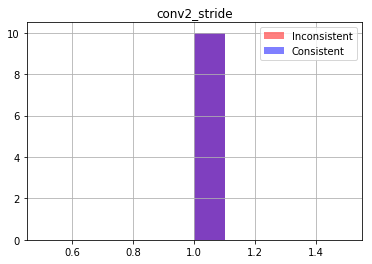

In [17]:
consistent_vs_inconsistent_histogram('conv2_stride')

# Distribution of conv2_dropout among consistent vs inconsistent models

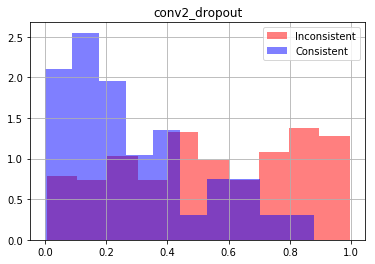

In [18]:
consistent_vs_inconsistent_histogram('conv2_dropout')

# Distribution of pool2_kernel_size among consistent vs inconsistent models

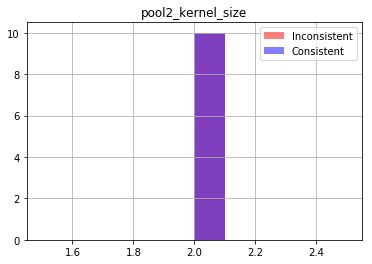

In [19]:
consistent_vs_inconsistent_histogram('pool2_kernel_size')

# Distribution of pool2_stride among consistent vs inconsistent models

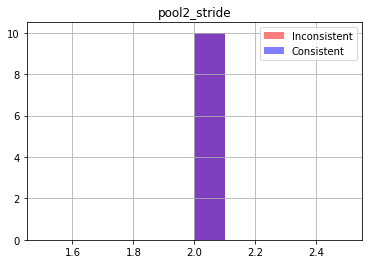

In [20]:
consistent_vs_inconsistent_histogram('pool2_stride')

# Distribution of fcs_hidden_size among consistent vs inconsistent models

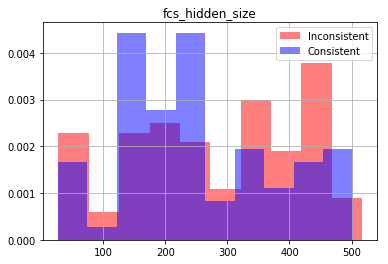

In [21]:
consistent_vs_inconsistent_histogram('fcs_hidden_size')

# Distribution of fcs_dropout among consistent vs inconsistent models

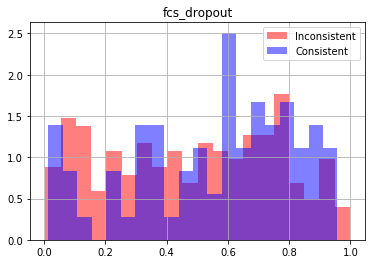

In [51]:
consistent_vs_inconsistent_histogram('fcs_dropout', bins=20)

# Distribution of fcs_num_hidden_layers among consistent vs inconsistent models

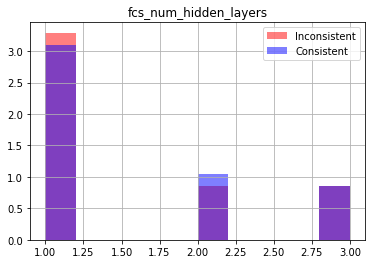

In [23]:
consistent_vs_inconsistent_histogram('fcs_num_hidden_layers')

# Percentage of Adam among consistent vs inconsistent models

In [58]:
print('inconsistent', len(df[~df['consistent'] & df['optimizer'].str.match('Adam')]) / len(df[~df['consistent']]))
print('consistent', len(df[df['consistent'] & df['optimizer'].str.match('Adam')]) / len(df[df['consistent']]))

inconsistent 0.4195121951219512
consistent 0.618421052631579


# Distribution of loss_val_k_4

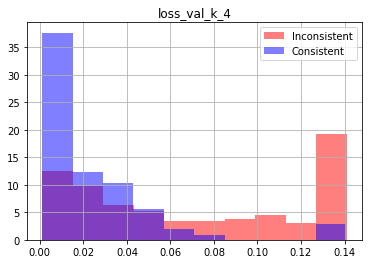

In [67]:
consistent_vs_inconsistent_histogram('loss_val_k_4')